## ESLiM analysis and figures (simulations, uncertainty analysis, sensitivity analysis)
Lindsey Gulden, 2025

Partial figures, tables, and analysis for 
[A critical assessment of the IPCC and IEA’s projections for carbon capture and storage](https://docs.google.com/document/d/1mwiSPu30LqLGQT-hkVah-VZzFI5dpKgsWUGA0rdgobI/edit?usp=sharing)

In [1]:
import warnings

import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

from projects.iam.eslim import NestedLogitIAM
from utils.calcs import scale_zero_to_one
from utils.io import yaml_to_dict

warnings.filterwarnings("ignore")

%load_ext jupyter_black


# bespoke function
def process_iam_output(in_df, time_list):
    """bespoke funciton to process outputs from IAM simulations"""
    in_df.index.name = "energy_source"
    if time_list == None:
        time_list = [2020, 2025, 2030, 2035, 2040, 2045, 2050]
    in_df.columns = [int(x) for x in time_list]


CONFIG_PATH = "/Users/lindseygulden/dev/leg-up-private/projects/iam/config/"
LHS_RESULTS_PATH = "/Users/lindseygulden/dev/leg-up-private/projects/iam/data/revised_data_20260114_lhs/"
SENSITIVITY_RESULTS_PATH = "/Users/lindseygulden/dev/leg-up-private/projects/iam/data/revised_data_20260113_sens_65536/"

## Get specific model configurations (e.g., baseline "IEA/IPCC default" parameters), midpoint parameters, etc

In [2]:
iam = NestedLogitIAM(CONFIG_PATH + "eslim_baseline_config.yml")
baseline_df = iam.simulate(True)  # used in paper

iam_baseline_weak = NestedLogitIAM(
    CONFIG_PATH + "eslim_baseline_config_weak_forcing.yml"
)
baseline_weak_forcing_df = iam_baseline_weak.simulate(
    True
)  # used only in fig 3 of paper

iam_realistic = NestedLogitIAM(CONFIG_PATH + "old_configs/sem_config_realistic.yml")
iam_realistic_df = iam_realistic.simulate(True)  # used in paper

iam_logit = NestedLogitIAM(CONFIG_PATH + "eslim_config_logit.yml")
logit_df = iam_logit.simulate(True)

iam_cost_markup = NestedLogitIAM(CONFIG_PATH + "eslim_config_ccs_cost_markup.yml")
cost_markup_df = iam_cost_markup.simulate(True)

iam_midrange = NestedLogitIAM(CONFIG_PATH + "eslim_config_midpoint.yml")
midpoint_df = iam_midrange.simulate(True)

iam_midrange_weak_forcing = NestedLogitIAM(
    CONFIG_PATH + "eslim_config_midpoint_weak_forcing.yml"
)
midrange_weak_df = iam_midrange_weak_forcing.simulate(True)

iam_midrange_strong_forcing = NestedLogitIAM(
    CONFIG_PATH + "eslim_config_midpoint_strong_forcing.yml"
)
midrange_strong_df = iam_midrange_strong_forcing.simulate(True)

iam_price = NestedLogitIAM(CONFIG_PATH + "eslim_config_co2_price.yml")
co2_price_forcing_df = iam_price.simulate(True)  # used in paper

iam_ccs_performance = NestedLogitIAM(CONFIG_PATH + "eslim_config_ccs_performance.yml")
ccs_perf_df = iam_ccs_performance.simulate(True)

iam_starting_price_pv = NestedLogitIAM(
    CONFIG_PATH + "eslim_config_starting_price_pv.yml"
)
starting_price_pv_df = iam_starting_price_pv.simulate(True)


iam_cost_trajectories = NestedLogitIAM(
    CONFIG_PATH + "eslim_config_tech_cost_trajectories.yml"
)
trajectories_df = iam_cost_trajectories.simulate(True)


# used in paper
# reformat outputs
for in_df in [
    baseline_df,
    iam_realistic_df,
    midpoint_df,
    midrange_strong_df,
    midrange_weak_df,
    logit_df,
    cost_markup_df,
    ccs_perf_df,
    co2_price_forcing_df,
    starting_price_pv_df,
    trajectories_df,
    baseline_weak_forcing_df,
]:
    process_iam_output(in_df, None)

### Basic figure: qualitative energy transition simulated with ESLiM

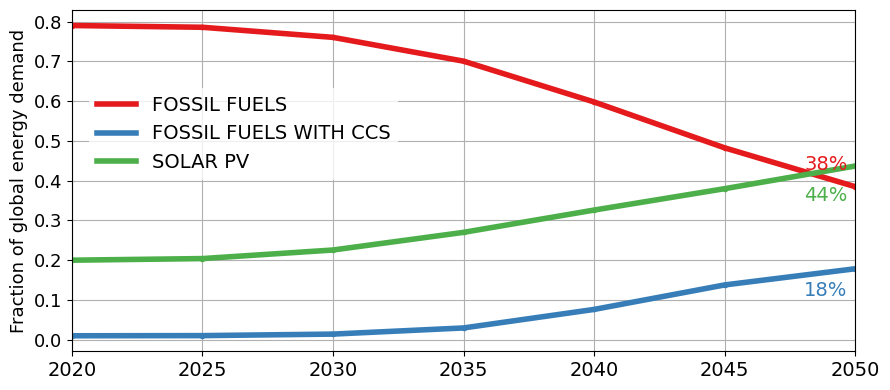

In [3]:
# Figure 2
plot_df = baseline_df  # midrange_weak_df
custom_colors = list(sns.color_palette("Set1", 3)) * 3

plt.rcParams["axes.prop_cycle"] = plt.cycler(color=custom_colors)

fig, ax = plt.subplots(1, 1, figsize=(9, 4))
baseline_lines = plt.plot(plot_df.T, marker=".", lw=4)

# legend handles for energy sources
baseline_handles = [
    Line2D(
        [0],
        [0],
        color=baseline_lines[i].get_color(),
        lw=4,
        label=plot_df.index[i].replace("_", " ").upper(),
    )
    for i in range(len(plot_df.index))
]

leg = plt.legend(
    handles=baseline_handles,
    loc="upper left",
    bbox_to_anchor=(0.01, 0.8),
    fontsize=14,
)
leg.get_frame().set_facecolor("white")
leg.get_frame().set_alpha(0.8)
leg.get_frame().set_linewidth(0.0)
# Add the custom lines to the legend


plt.grid()
plt.ylabel("Fraction of global energy demand", fontsize=13)
plt.xticks(fontsize=14)
plt.yticks(fontsize=13)
plt.xlim(2020, 2050)
# add 2050 percentages for each of the three:
# fossil ccs
adjusts = [0.08, -0.03, -0.05]
for i, e in enumerate(
    [
        "fossil_fuels",
        "fossil_fuels_with_CCS",
        "solar_pv",
    ]
):
    pct = plot_df.loc[e, 2050] * 100
    vertical_loc = plot_df.loc[e, 2050] + adjusts[i]
    plt.text(
        2049.7,
        vertical_loc,
        f"{pct:.0f}%",
        horizontalalignment="right",
        verticalalignment="top",
        fontsize=14,
        color=custom_colors[i],
    )

fig.tight_layout()
fig.savefig("fig_2.png")
fig.savefig("fig_2.pdf")
# plt.show()

### Figure S7: Varying parameters one at a time to see how that affects final simulated fractions

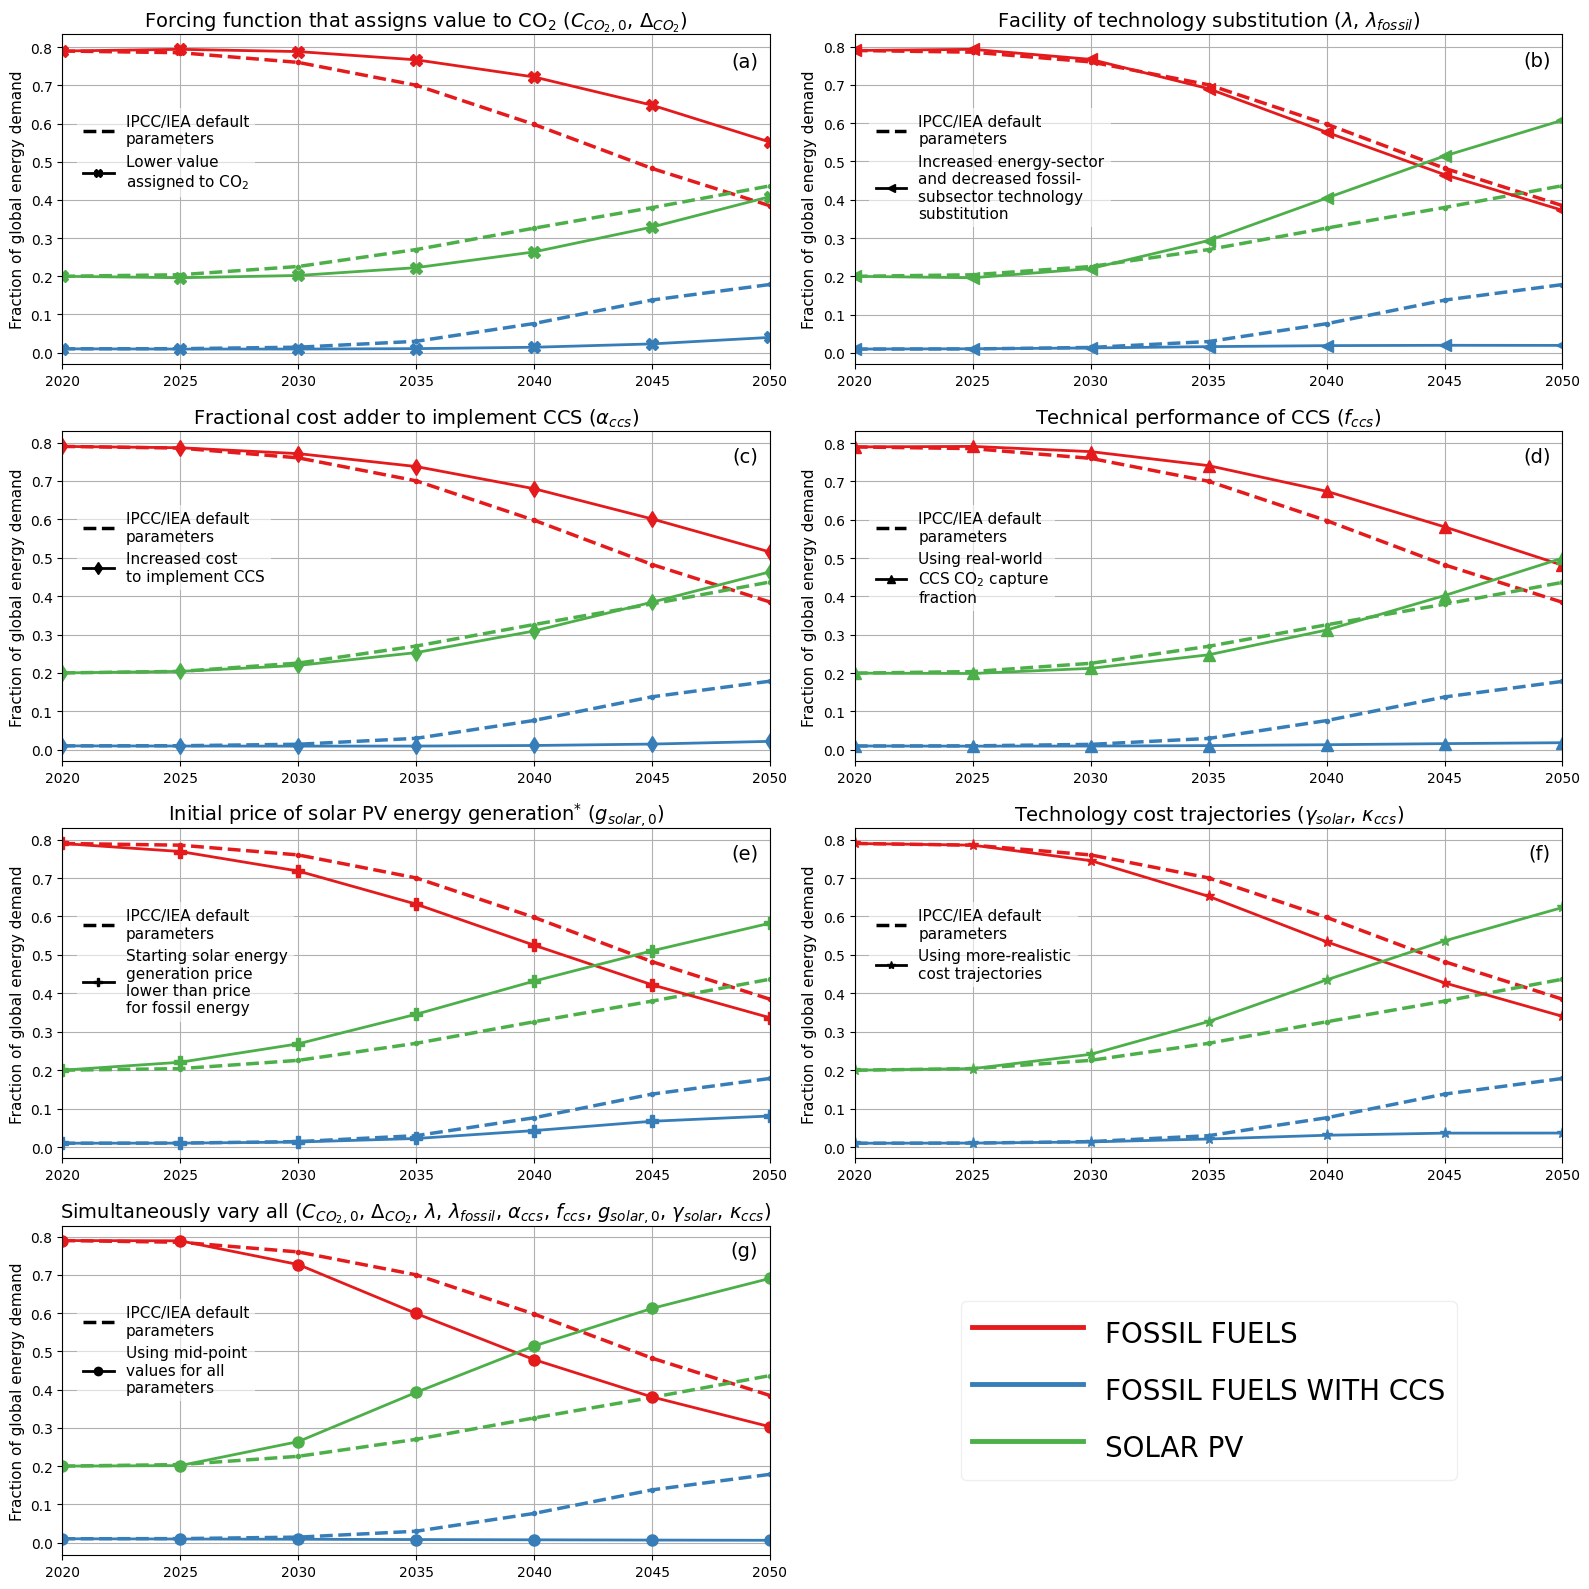

In [4]:
# figure 3
custom_colors = list(sns.color_palette("Set1", 3)) * 3
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=custom_colors)


titlefontsize = 14
yfontsize = 11
baselinemarker = "."
baselinelw = 2.5
markers = ["X", "<", "d", "^", "P", "*", "o"]
markersize = 8
lws = [2] * 7
linestyles = ["-"] * 7
labels = [
    "Lower value\nassigned to " + r"${\mathrm{CO_2}}$",
    "Increased energy-sector\nand decreased fossil-\nsubsector technology\nsubstitution",
    "Increased cost\nto implement CCS",
    "Using real-world\n" + r"CCS ${\mathrm{CO_2}}$" + " capture\nfraction",
    "Starting solar energy\ngeneration price\nlower than price\nfor fossil energy",
    "Using more-realistic\ncost trajectories",
    "Using mid-point\nvalues for all\nparameters",
]
titles = [
    r"Forcing function that assigns value to ${\mathrm{CO_2}}$ ($C_{CO_2,0}$, $\Delta_{CO_2}$)",
    r"Facility of technology substitution ($\lambda$, $\lambda_{\mathit{fossil}}$)",
    r"Fractional cost adder to implement CCS ($\alpha_{\mathit{ccs}}$)",
    r"Technical performance of CCS ($f_{\mathit{ccs}}$)",
    r"Initial price of solar PV energy generation$^{*}$ ($g_{\mathit{solar},0}$)",
    r"Technology cost trajectories ($\gamma_{\mathit{solar}}$, $\kappa_{\mathit{ccs}}$)",
    r"Simultaneously vary all ($C_{CO_2,0}$, $\Delta_{CO_2}$, $\lambda$, $\lambda_{\mathit{fossil}}$, $\alpha_{\mathit{ccs}}$, $f_{\mathit{ccs}}$, $g_{\mathit{solar},0}$, $\gamma_{\mathit{solar}}$, $\kappa_{\mathit{ccs}}$)",
]


panels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)"]
nrows = 4
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(16, (nrows * 4)))

# -- cycle through parameters ---
for i, plot_df in enumerate(
    [
        co2_price_forcing_df,
        logit_df,
        cost_markup_df,
        ccs_perf_df,
        starting_price_pv_df,
        trajectories_df,
        midpoint_df,
    ]
):
    plt.subplot(nrows, ncols, i + 1)
    baseline_lines = plt.plot(
        baseline_df.T, marker=baselinemarker, lw=baselinelw, ls="--"
    )
    other_lines = plt.plot(
        plot_df.T,
        marker=markers[i],
        linestyle=linestyles[i],
        lw=lws[i],
        markersize=markersize,
    )
    plt.title(titles[i].replace("\n", " "), fontsize=titlefontsize)
    # Create legend lines (black to show meaning associated with difference in line styles that applies across color groupings)
    default_line = Line2D(
        [0],
        [0],
        color="black",
        lw=baselinelw,
        ls="--",
        label="IPCC/IEA default\nparameters",
    )  # Solid line
    realistic_line = Line2D(
        [0],
        [0],
        color="black",
        lw=lws[i],
        ls=linestyles[i],
        marker=markers[i],
        label=labels[i],
    )
    handles = [default_line, realistic_line]
    loc_leg = plt.legend(
        handles=handles,
        fontsize=11,
        bbox_to_anchor=(0.01, 0.8),
        loc="upper left",
    )
    frame = loc_leg.get_frame()
    frame.set_facecolor("white")
    frame.set_alpha(0.6)
    frame.set_linewidth(0.0)
    # loc_leg.set_frame_on(False)
    plt.ylabel("Fraction of global energy demand", fontsize=yfontsize)
    plt.grid(True, zorder=0)
    plt.xlim((2020, 2050))

    # append panel label
    plt.text(
        2049.5,
        0.79,
        panels[i],
        horizontalalignment="right",
        verticalalignment="top",
        fontsize=14,
    )


# Create legend handles for baseline sources
baseline_handles = [
    Line2D(
        [0],
        [0],
        color=baseline_lines[i].get_color(),
        lw=4,
        label=baseline_df.index[i].replace("_", " ").upper(),
    )
    for i in range(len(baseline_df.index))
]

plt.subplot(nrows, ncols, int(nrows * ncols))
plt.axis("off")
# custom legend for bottom right plot

baseline_handles = [
    Line2D(
        [0],
        [0],
        color=baseline_lines[i].get_color(),
        lw=baselinelw + 1,
        label=baseline_df.index[i].replace("_", " ").upper(),
    )
    for i in range(len(baseline_df.index))
]
leg = plt.legend(
    handles=baseline_handles,
    handlelength=4,  # 🔑 default is ~2, increase this for longer lines
    handleheight=2,  # optional, affects vertical spacing
    loc="center",
    fontsize=20,
)  #
leg.get_frame().set_facecolor("white")
leg.get_frame().set_alpha(0.3)
# leg.set_frame_on(False)
fig.tight_layout()
fig.savefig("fig_s7.png")
fig.savefig("fig_s7.pdf")

### Figure 3 Comparison of energy shares simulated with IEA/IPCC default and midpoint parameters under strong and weak carbon-price forcing

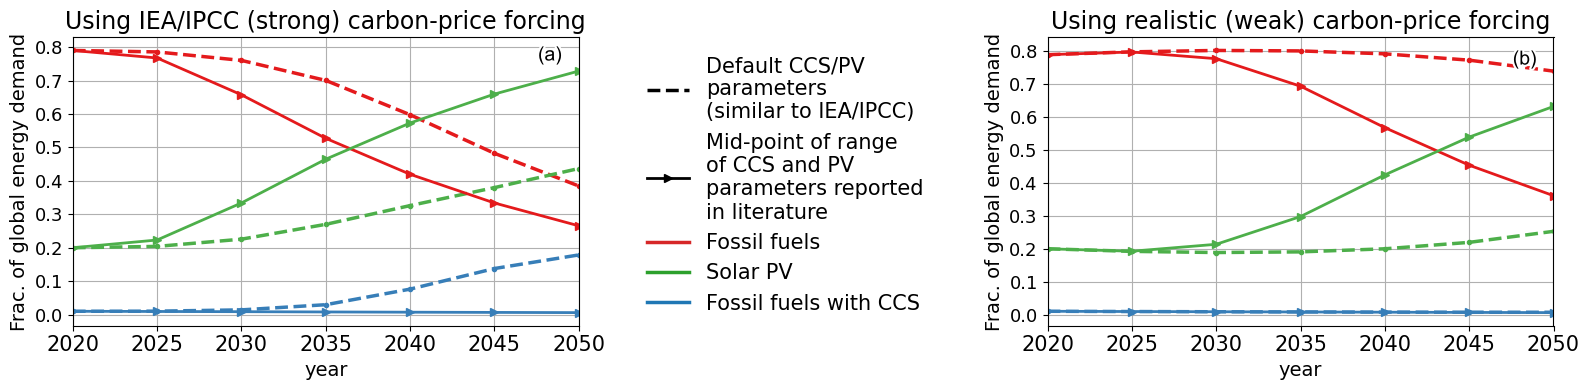

In [5]:
# compare with and without realistic forcing

custom_colors = list(sns.color_palette("Set1", 3)) * 3
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=custom_colors)

titlefontsize = 17
yfontsize = 14
baselinemarker = "."
baselinelw = 2.5
midrange_lw = 2
markers = ["X", "<", "d", "^", "P", "*", "o"]
markersize = 8
marker = ">"
lws = [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]
linestyles = ["_"] * 7
ytickfontsize = 13
xtickfontsize = 15

panels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)"]

fig, axes = plt.subplots(1, 3, width_ratios=[5.5, 2, 5.5], figsize=(16, 4))

i = 1
plt.subplot(1, 3, i)

baseline_lines = plt.plot(
    baseline_df.T, marker=baselinemarker, lw=baselinelw, linestyle="--"
)
other_lines = plt.plot(
    midrange_strong_df.T,
    marker=marker,
    linestyle="-",
    lw=midrange_lw,
    # markersize=markersize,
)
axes[i - 1].set_title(
    "Using IEA/IPCC (strong) carbon-price forcing", fontsize=titlefontsize
)

i = 3
plt.subplot(1, 3, i)
baseline_lines = plt.plot(
    baseline_weak_forcing_df.T, marker=baselinemarker, lw=baselinelw, linestyle="--"
)
other_lines = plt.plot(
    midrange_weak_df.T,
    marker=marker,
    linestyle="-",
    lw=midrange_lw,
    # markersize=markersize,
)
axes[i - 1].set_title(
    "Using realistic (weak) carbon-price forcing", fontsize=titlefontsize
)
# add panel labels for both panels with time series


axes[0].text(
    2049,
    0.76,
    "(a)",
    font="Arial",
    fontsize=14,
    color="k",
    horizontalalignment="right",
    path_effects=[pe.withStroke(linewidth=3, foreground="white")],  # Halo effect
)
axes[2].text(
    2049,
    0.76,
    "(b)",
    font="Arial",
    fontsize=14,
    color="k",
    horizontalalignment="right",
    path_effects=[pe.withStroke(linewidth=3, foreground="white")],  # Halo effect
)

# make legend for center subplot
plt.subplot(1, 3, 2)
ccs_line = Line2D(
    [0],
    [0],
    color="tab:blue",
    lw=2.5,
    ls="-",
    label="Fossil fuels with CCS",
)
solar_line = Line2D(
    [0],
    [0],
    color="tab:green",
    lw=2.5,
    ls="-",
    label="Solar PV",
)
ff_line = Line2D(
    [0],
    [0],
    color="tab:red",
    lw=2.5,
    ls="-",
    label="Fossil fuels",
)
default_line = Line2D(
    [0],
    [0],
    color="black",
    lw=baselinelw,
    ls="--",
    label="Default CCS/PV\nparameters\n(similar to IEA/IPCC)",
)  # Solid line
realistic_line = Line2D(
    [0],
    [0],
    color="black",
    lw=midrange_lw,
    ls="-",
    marker=marker,
    label="Mid-point of range\nof CCS and PV\nparameters reported\nin literature",
)
handles = [default_line, realistic_line, ff_line, solar_line, ccs_line]

loc_leg = plt.legend(
    handles=handles, fontsize=15, bbox_to_anchor=(1.2, 1)
)  # loc="center")
frame = loc_leg.get_frame()
frame.set_facecolor("white")
frame.set_alpha(0.6)
frame.set_linewidth(0.0)
plt.axis("off")


# adjust lineplot axes and fontsizes for subplots 0 and 2
for i in [0, 2]:
    axes[i].set_ylabel("Frac. of global energy demand", fontsize=yfontsize)
    axes[i].grid("both")
    axes[i].set_xlim([2020, 2050])
    axes[i].set_xticklabels(axes[i].get_xticklabels(), fontsize=xtickfontsize)
    axes[i].set_yticklabels(axes[i].get_yticklabels(), fontsize=ytickfontsize)
    axes[i].set_xlabel("year", fontsize=14)

fig.tight_layout()
fig.savefig("fig_3.pdf")
fig.savefig("fig_3.png")

## Make figures describing the LHS uncertainty ensemble and the Saltelli global sensitivity analysis

### Read in LHS Uncertainty Ensemble and the Saltelli sensitivity outputs

In [6]:
# LHS uncertainty ensemble
df = pd.read_csv(LHS_RESULTS_PATH + "simulation_outputs.csv")
df.columns = [
    "energy_source",
    "2020",
    "2025",
    "2030",
    "2035",
    "2040",
    "2045",
    "2050",
    "iteration",
]
# SA outputs
s1_df = pd.read_csv(SENSITIVITY_RESULTS_PATH + "S1_results.csv")
st_df = pd.read_csv(SENSITIVITY_RESULTS_PATH + "s_total_results.csv")
# s2_df = pd.read_csv(SENSITIVITY_RESULTS_PATH + "S2_results.csv")
pars_df = pd.read_csv(LHS_RESULTS_PATH + "simulation_parameters.csv")

### Table S4: Sensitivity analysis table outputs

In [7]:
st_df.merge(s1_df, on="parameter").sort_values(by="ST", ascending=False).to_clipboard()
st_df.merge(s1_df, on="parameter").sort_values(by="ST", ascending=False)

,parameter,ST,ST_conf,S1,S1_conf
2,ccs_capture_fraction,0.388212,0.118121,0.016539,0.005066
3,solar_pv_learning_curve,0.344782,0.119404,0.057349,0.012731
6,energy_sector_logit_exponent,0.328600,0.081568,0.061922,0.016423
1,ccs_cost_adder_fraction,0.326067,0.104746,0.047577,0.010588
8,co2_total_increase_in_price,0.234638,0.067994,0.000235,0.002916
0,starting_price_solar_pv,0.222839,0.064304,0.043530,0.011236
5,fossil_subsector_logit_exponent,0.217810,0.064203,0.058252,0.016422
4,ccs_learning_curve,0.072809,0.030084,0.004553,0.005414
7,co2_starting_price,0.025138,0.010595,0.000612,0.001193


In [8]:
16 * 4096

65536

In [9]:
# get bounds of uniform distributions used for UA/SA.

sensitivity_pars = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/iam/config/sensitivity_config.yml"
)["pars_to_vary"]

# Specify IEA/IPCC default values

default_dict = {
    "ccs_capture_fraction": 0.9,
    "ccs_cost_adder_fraction": 0.4,
    "ccs_learning_curve": 0.1,
    "co2_starting_price": 50,
    "co2_total_increase_in_price": 200,
    "energy_sector_logit_exponent": -3,
    "fossil_subsector_logit_exponent": -10,
    "solar_pv_learning_curve": 0.1,
    "starting_price_solar_pv": 100,
}

# assemble dataframe with both sets of info in it for use in scaling and plotting, below
row_list = []
for d in sensitivity_pars:
    row_dict = dict()
    row_dict["name"] = d["name"]
    row_dict["minval"] = d["bounds"][0]
    row_dict["maxval"] = d["bounds"][1]
    row_dict["default"] = default_dict[d["name"]]
    row_dict["default_scaled"] = scale_zero_to_one(
        default_dict[d["name"]], d["bounds"][0], d["bounds"][1]
    )
    row_list.append(row_dict)

plausible_df = pd.DataFrame(row_list).set_index("name")


# scale ensemble parameters to 0
scaled_pars_df = pars_df.copy()
for c in [x for x in scaled_pars_df.columns.values if x != "ccs_2050"]:
    minval = plausible_df.loc[c, "minval"]
    maxval = plausible_df.loc[c, "maxval"]
    scaled_pars_df[c] = [
        scale_zero_to_one(float(x), minval, maxval) if isinstance(x, float) else np.nan
        for x in scaled_pars_df[c]
    ]

scaled_pars_df["ccs_2050"] = list(
    df["2050"].loc[df.energy_source == "fossil_fuels_with_CCS"]
)

### Figure 5: Parameter distributions for the 0.1% of ESLiM ensemble members with the highest simulated fossil-with-CCS share

0.025449013025554145

500


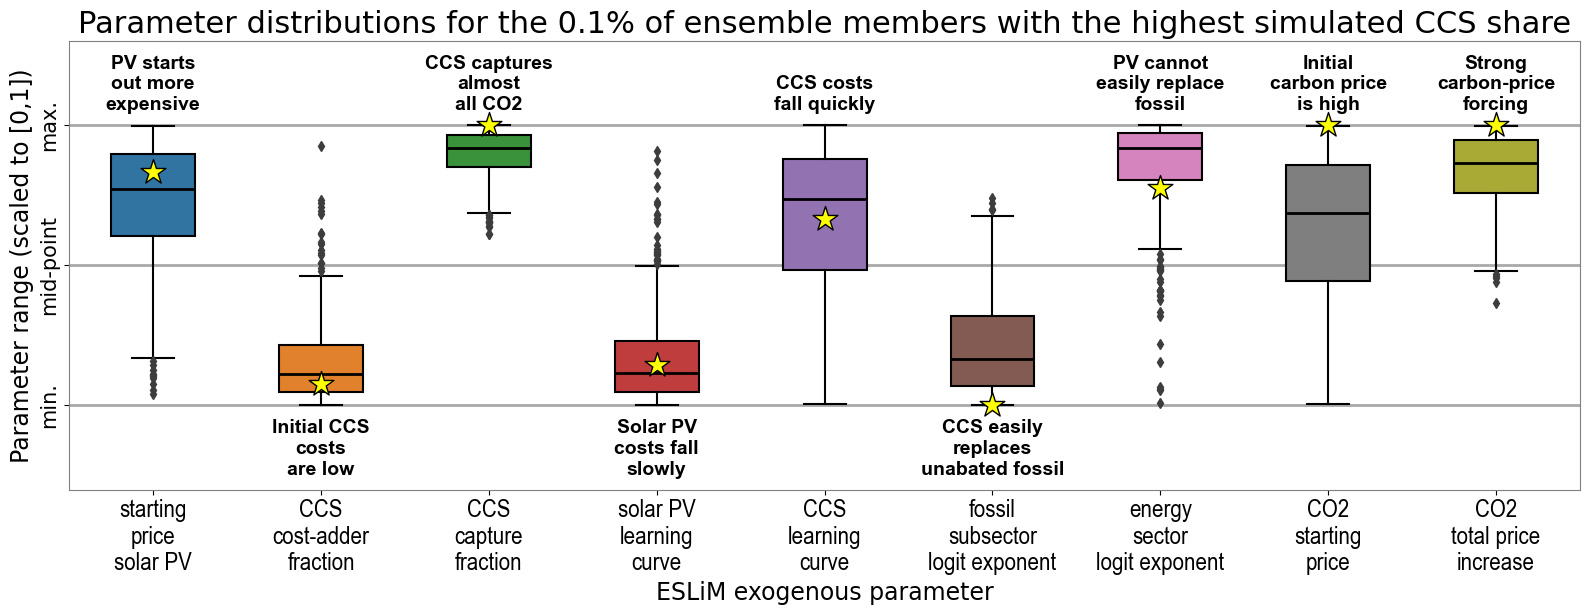

In [10]:
v = scaled_pars_df["ccs_2050"].quantile(0.999)
print(v)
print("")
print(len(scaled_pars_df.loc[scaled_pars_df.ccs_2050 >= v]))


fig, ax = plt.subplots(1, 1, figsize=(16, 6.25))
sns.boxplot(
    scaled_pars_df.loc[scaled_pars_df.ccs_2050 >= v].drop("ccs_2050", axis=1),
    ax=ax,
    width=0.5,
    zorder=10,
    palette="tab10",
    boxprops=dict(edgecolor="black", linewidth=1.5),
    whiskerprops=dict(color="black", linewidth=1.5),
    capprops=dict(color="black", linewidth=1.5),
    medianprops=dict(color="black", linewidth=2),
)
labels = ax.get_xticklabels()
param_order = [x.get_text() for x in labels]

# add defaults with stars
for i, p in enumerate(param_order):
    plt.scatter(
        i,
        plausible_df.loc[p, "default_scaled"],
        marker="*",
        color="yellow",
        edgecolor="k",
        linewidth=1,
        s=350,
        zorder=12,
    )
# make x labels more readable
ax.set_ylim(-0.3, 1.3)
ax.set_xticklabels(
    labels=[
        x.get_text()
        .replace("_", "\n")
        .replace("ccs", "CCS")
        .replace("pv", "PV")
        .replace("co2", "CO2")
        .replace("solar\nPV", "solar PV")
        .replace("total\nincrease\nin\nprice", "total price\nincrease")
        .replace("cost\nadder", "cost-adder")
        .replace("logit\nexponent", "logit exponent")
        for x in labels
    ],
    rotation=0,
    font="Arial Narrow",
    fontsize=18,
)
ax.set_yticks(
    [0, 0.5, 1],
    labels=["min.", "mid-point", "max."],
)
ax.set_yticklabels(
    labels=["min.", "mid-point", "max."], fontsize=15, rotation=90, va="center"
)
ax.grid(axis="y", zorder=0, color="darkgray", lw=2)
ax.set_title(
    "Parameter distributions for the 0.1% of ensemble members with the highest simulated CCS share",
    fontsize=22,
)
ax.set_xlabel("ESLiM exogenous parameter", fontsize=17)

# TEXT ANNOTATIONS
fontsize = 14
font = "Arial"
weight = "bold"
ax.text(
    0,
    1.04,
    "PV starts\nout more\nexpensive",
    va="bottom",
    ha="center",
    fontsize=fontsize,
    font=font,
    weight=weight,
)
ax.text(
    1,
    -0.05,
    "Initial CCS\ncosts\nare low",
    va="top",
    ha="center",
    fontsize=fontsize,
    font=font,
    weight=weight,
)
ax.text(
    2,
    1.04,
    "CCS captures\nalmost\nall CO2",
    va="bottom",
    ha="center",
    fontsize=fontsize,
    font=font,
    weight=weight,
)
ax.text(
    3,
    -0.05,
    "Solar PV\ncosts fall\nslowly",
    va="top",
    ha="center",
    fontsize=fontsize,
    font=font,
    weight=weight,
)
ax.text(
    4,
    1.04,
    "CCS costs\nfall quickly",
    va="bottom",
    ha="center",
    fontsize=fontsize,
    font=font,
    weight=weight,
)
ax.text(
    5,
    -0.05,
    "CCS easily\nreplaces\nunabated fossil",
    va="top",
    ha="center",
    fontsize=fontsize,
    font=font,
    weight=weight,
)
ax.text(
    6,
    1.04,
    "PV cannot\neasily replace\nfossil",
    va="bottom",
    ha="center",
    fontsize=fontsize,
    font=font,
    weight=weight,
)
ax.text(
    7,
    1.04,
    "Initial\ncarbon price\nis high",
    va="bottom",
    ha="center",
    fontsize=fontsize,
    font=font,
    weight=weight,
)
ax.text(
    8,
    1.04,
    "Strong\ncarbon-price\nforcing",
    va="bottom",
    ha="center",
    fontsize=fontsize,
    font=font,
    weight=weight,
)

for spine in ax.spines.values():
    spine.set_linewidth(0.8)
    spine.set_color("gray")
ax.set_ylabel("Parameter range (scaled to [0,1])", fontsize=17)
ax.set_axisbelow(True)
fig.tight_layout()
fig.savefig("fig_5.pdf")
fig.savefig("fig_5.png")

### Supplementary Appendix Figure S9: linear correlation between parameter values and model outputs

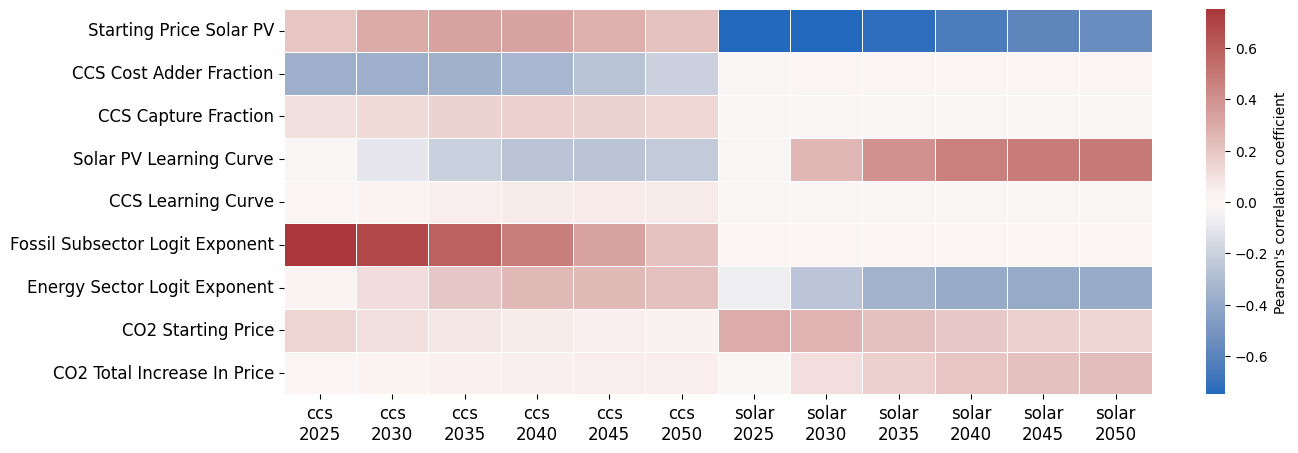

In [11]:
# prep work for Figure S9
# reformat outputs to focus on CCS and solar through timesteps

ccs_df = df.loc[df.energy_source == "fossil_fuels_with_CCS"]
ccs_df.columns = ["ccs_" + x if len(x) == 4 else x for x in ccs_df.columns.values]
ccs_df.drop("energy_source", axis=1, inplace=True)
solar_df = df.loc[df.energy_source == "solar_pv"]
solar_df.drop("energy_source", axis=1, inplace=True)
solar_df.columns = ["solar_" + x if len(x) == 4 else x for x in solar_df.columns.values]
solar_ccs_df = ccs_df.merge(
    solar_df.merge(pars_df, left_on="iteration", right_index=True),
    on="iteration",
)

### Get correlation matrix
corr_df = solar_ccs_df.corr()

pars = list(pars_df.columns.values)
outputs = [
    "ccs_2025",
    "ccs_2030",
    "ccs_2035",
    "ccs_2040",
    "ccs_2045",
    "ccs_2050",
    "solar_2025",
    "solar_2030",
    "solar_2035",
    "solar_2040",
    "solar_2045",
    "solar_2050",
]

# Figure S9
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
sns.heatmap(
    data=corr_df.loc[pars, outputs],
    cmap="vlag",
    vmin=-0.75,
    vmax=0.75,
    ax=ax,
    edgecolor="black",
    linewidths=0.5,
    cbar_kws={"label": "Pearson's correlation coefficient"},
)
ax.set_yticklabels(
    [
        x.replace("_", " ")
        .title()
        .replace("Ccs", "CCS")
        .replace("Pv", "PV")
        .replace("Co2", "CO2")
        .replace("Of", "of")
        .replace("Per", "per")
        for x in pars
    ],
    fontsize=12,
)
ax.set_xticklabels([x.replace("_", "\n") for x in outputs], rotation=0, fontsize=12)
fig.savefig("fig_s9.pdf")
fig.savefig("fig_s9.png")

### Look at entire dataset of simulation outputs and show how distribution of shares changes across time

In [12]:
# dataprep for fig s8 (time series of distributijon change for LHS ensemble
melt_df = df.melt(
    id_vars=["energy_source", "iteration"],
    value_vars=[str(x) for x in [2020, 2025, 2030, 2035, 2040, 2045, 2050]],
    value_name="share",
    var_name="time",
)

baseline_melt_df = baseline_df.reset_index().melt(
    id_vars=["energy_source"],
    value_vars=[int(x) for x in [2020, 2025, 2030, 2035, 2040, 2045, 2050]],
    value_name="share",
    var_name="time",
)
baseline_melt_df["time"] = baseline_melt_df["time"].astype(str)


# get median values for plotting to assist visual interpretation
median_df = df.groupby("energy_source").median().reset_index()
median_df.drop("iteration", axis=1, inplace=True)
median_df = median_df.melt(id_vars="energy_source", var_name="time", value_name="share")

### Figure S8: Ensemble simulated energy transition through time

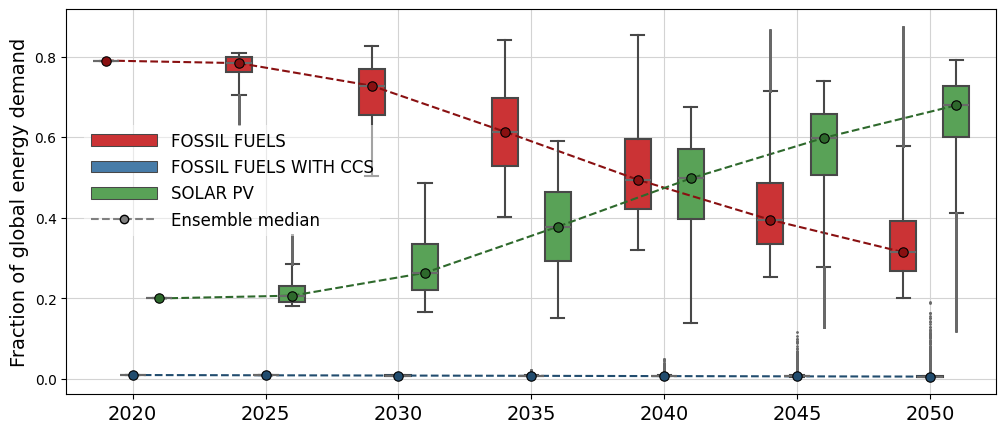

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# Define palette
hue_order = melt_df["energy_source"].unique()
base_palette = sns.color_palette("Set1", n_colors=len(hue_order))
darker_palette = sns.color_palette(
    [(r * 0.6, g * 0.6, b * 0.6) for r, g, b in base_palette]
)

# Pointplot (set zorder > 0 to be above grid)
sns.pointplot(
    data=median_df,
    x="time",
    y="share",
    hue="energy_source",
    hue_order=hue_order,
    palette=darker_palette,
    dodge=0.4,
    markers="o",
    scale=1,
    errorbar=None,
    linestyles="--",
    join=True,
    ax=ax,
)
for line in ax.lines:
    line.set_linewidth(1.5)
    line.set_linestyle("--")
    line.set_markersize(5)
    line.set_zorder(5)  # ensure above grid

for collection in ax.collections:
    collection.set_edgecolor("black")
    collection.set_linewidth(0.8)
    collection.set_zorder(5)  # ensure above grid

# Boxplot (zorder already low so behind points)
sns.boxplot(
    data=melt_df,
    x="time",
    y="share",
    hue="energy_source",
    hue_order=hue_order,
    palette=base_palette,
    width=0.6,
    ax=ax,
    flierprops=dict(
        marker=".",
        markersize=2,
        markeredgecolor="dimgrey",
        linewidth=0.5,
    ),
    medianprops=dict(
        color="dimgray",
        linewidth=1.5,
        linestyle="-",
    ),
    zorder=1,
)

# Labels
ax.set_xlabel("")
ax.set_ylabel("Fraction of global energy demand", fontsize=14)
ax.set_xticklabels(
    labels=[str(x) for x in [2020, 2025, 2030, 2035, 2040, 2045, 2050]],
    fontsize=14,
)

# Legend
handles, labels = ax.get_legend_handles_labels()
handles, labels = handles[-3:], labels[-3:]

custom = Line2D(
    [0],
    [0],
    color="grey",
    linestyle="--",
    linewidth=1.5,
    marker="o",
    markersize=6,
    markerfacecolor="grey",
    markeredgecolor="black",
    label="Ensemble median",
)

handles.append(custom)
labels.append("Ensemble median")
labels = [x.upper().replace("_", " ") if x != "Ensemble median" else x for x in labels]


leggy = ax.legend(
    handles,
    labels,
    handlelength=4,
    fontsize=12,
    title=None,
    bbox_to_anchor=(0.01, 0.72),
    loc="upper left",
)
leggy.get_frame().set_facecolor("white")
leggy.get_frame().set_alpha(0.5)
leggy.get_frame().set_linewidth(0.0)

# --- order everything ---
# grid goes behind everything
ax.grid(True, zorder=-1, color="lightgray")
for patch in ax.patches:
    patch.set_zorder(2)

# median lines go above grid
for line in ax.lines:
    line.set_zorder(3)

#  points are above grid
for collection in ax.collections:
    collection.set_zorder(4)

fig.savefig("fig_s8.pdf")
fig.savefig("fig_s8.png")

### Table data for paper table S3 -- stats to describe LHS ensemble

In [ ]:
# Raw output for stats table to describe ensemble (Table 3)

# adjust column names for midpoint and default parameter results for later merging with percentiles:
midpoint_df.columns = ["midpoint_pars_" + str(x) for x in midpoint_df.columns.values]
baseline_df.columns = ["default_pars_" + str(x) for x in baseline_df.columns.values]

stats_df = (
    df[["energy_source", "2050"]]
    .groupby("energy_source")
    .agg(["mean", "std", "median", "min", "max"])
    .reset_index()
)
stats_df.columns = [
    "energy_source",
    "mean_share_in_2050",
    "std_of_2050_share",
    "median_share_in_2050",
    "min_share_in_2050",
    "max_share_in_2050",
]


# get percetnile iin distribution

row_list = []

for e in df.energy_source.unique():
    row_dict = {}
    row_dict["energy_source"] = e
    row_dict["IEA/IPCC-inspired parameters"] = stats.percentileofscore(
        df[["energy_source", "2050"]].loc[df.energy_source == e]["2050"].to_list(),
        baseline_df.loc[e, "default_pars_2050"],
        kind="mean",
    )
    row_dict["mid-point parameters"] = stats.percentileofscore(
        df[["energy_source", "2050"]].loc[df.energy_source == e]["2050"].to_list(),
        midpoint_df.loc[e, "midpoint_pars_2050"],
        kind="mean",
    )
    row_list.append(row_dict.copy())

percentile_df = pd.DataFrame(row_list)


percentile_df.merge(stats_df, on="energy_source").to_clipboard()
percentile_df = percentile_df.merge(stats_df, on="energy_source")
percentile_df.set_index("energy_source", inplace=True)
percentile_df = percentile_df.join(midpoint_df["midpoint_pars_2050"])
percentile_df = percentile_df.join(baseline_df["default_pars_2050"])
percentile_df.to_clipboard()
percentile_df

,IEA/IPCC-inspired parameters,mid-point parameters,mean_share_in_2050,std_of_2050_share,median_share_in_2050,min_share_in_2050,max_share_in_2050,midpoint_pars_2050,default_pars_2050
energy_source,,,,,,,,,
fossil_fuels,73.4826,44.0874,0.346365,0.112643,0.314573,0.201858,0.873809,0.302978,0.384691
fossil_fuels_with_CCS,99.9996,41.2532,0.006613,0.002011,0.006106,0.005645,0.190035,0.005972,0.178503
solar_pv,6.6188,56.0564,0.647022,0.113400,0.679084,0.120065,0.792489,0.691050,0.436806


In [22]:
df["2050"].loc[df["energy_source"] == "fossil_fuels_with_CCS"].quantile(0.99)

0.012149396204988838

### Figure 4: 2050 simulated shares of energy sources: ensemble distributions compared to realistic and default parameters


#### Version 1 (no midpoint parameters plotted)

KeyError: 2050

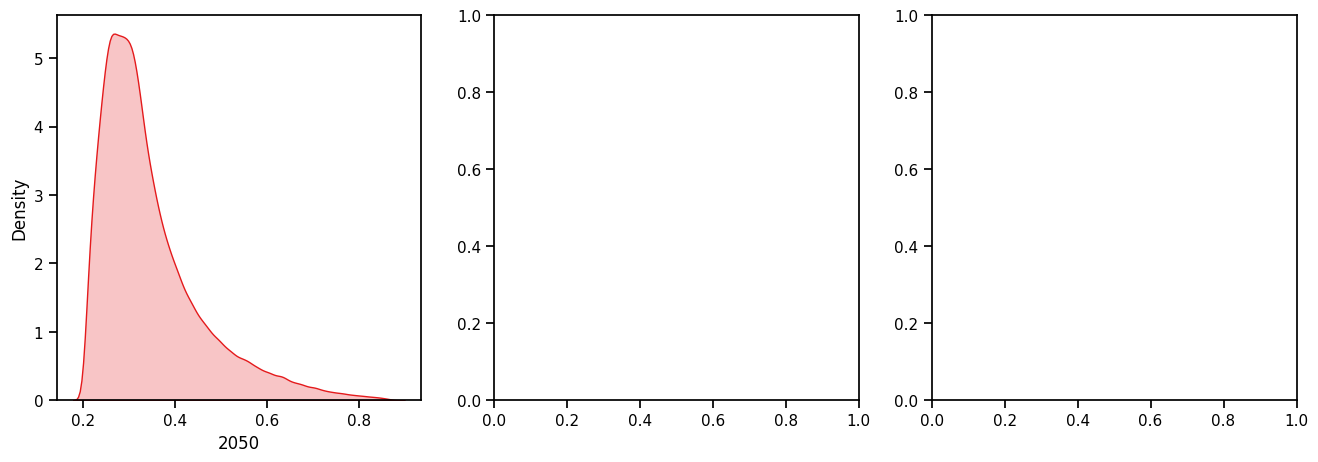

In [15]:
# Figure 5
sns.set_context("notebook")
locations = ["upper right", "center right", "upper left"]
energy_sources = list(df["energy_source"].unique())
base_palette = sns.color_palette("Set1", n_colors=len(energy_sources))

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, e in enumerate(energy_sources):
    ax = axes[i]

    # distribution of ensemble member results
    kdeplot = sns.kdeplot(
        data=df.loc[df.energy_source == e, "2050"],
        common_norm=True,
        ax=ax,
        fill=True,
        color=base_palette[i],
    )

    # baseline simulation result for each energy source
    ax.plot(
        [baseline_df.loc[e, 2050]] * 2,
        ax.get_ylim(),
        color="k",  # base_palette[i],
        ls="--",
        lw=1.5,
    )

    # adjust x axis limits
    ax.set_xlim(
        [
            df.loc[df.energy_source == e, "2050"].min() - 0.02,
            df.loc[df.energy_source == e, "2050"].quantile(0.9995) + 0.02,
        ]
    )
    for spine in ax.spines.values():
        spine.set_linewidth(0.8)
        spine.set_color("gray")

    # Labels and title
    ax.set_title(e.replace("_", " ").upper(), fontsize=16)
    if e == "fossil_fuels":
        ax.set_title("UNABATED FOSSIL FUELS", fontsize=16)

    ax.set_xlabel("Simulated share of 2050 global energy demand")
    if i > 0:
        ax.set_ylabel("")
# --- add annotations ---
# fossil fuels panel
axes[0].text(
    0.445,
    3.7,
    "Share simulated\nwith typical ESM\nparameters",
    fontsize=10,
)
axes[0].text(
    0.64,
    0.44,
    "Distribution of\n100,000 ensemble\nmembers'\nsimulated\nshares",
    font="Arial Narrow",
    ha="right",
)
axes[0].set_ylim(0.0, 5.9)

# add annotations to fossil fuels with CCS panel
axes[1].set_xlim(0.0, 0.15)
axes[1].set_ylim(0, 950)
axes[1].text(
    0.14,
    340,
    "Share\nsimulated with\ntypical ESM\nparameters",  # \n(>99.99% of all\nsimulated shares)",
    fontsize=10,
    ha="right",
)
axes[1].text(
    0.026,
    70,
    "Distribution of 100,000\nensemble members'\nsimulated shares",
    font="Arial Narrow",
)
axes[1].annotate(
    "", xytext=(0.025, 90), xy=(0.01, 20), arrowprops=dict(arrowstyle="->")
)

# add annotations to solar PV share panel
axes[2].text(
    0.41,
    3,
    "Share\nsimulated with\ntypical ESM\nparameters",
    ha="right",
    fontsize=10,
)
axes[2].set_ylim(0, 5.9)

axes[2].text(
    0.68,
    1.25,
    "Distribution of\n100,000 ensemble\nmembers' simulated\nshares",
    ha="right",
    font="Arial Narrow",
)

# tighten things up and save!
fig.tight_layout()
# fig.savefig("fig_4.png")
# fig.savefig("fig_4.pdf")

#### version 2 (with midpoint paramters plotted)

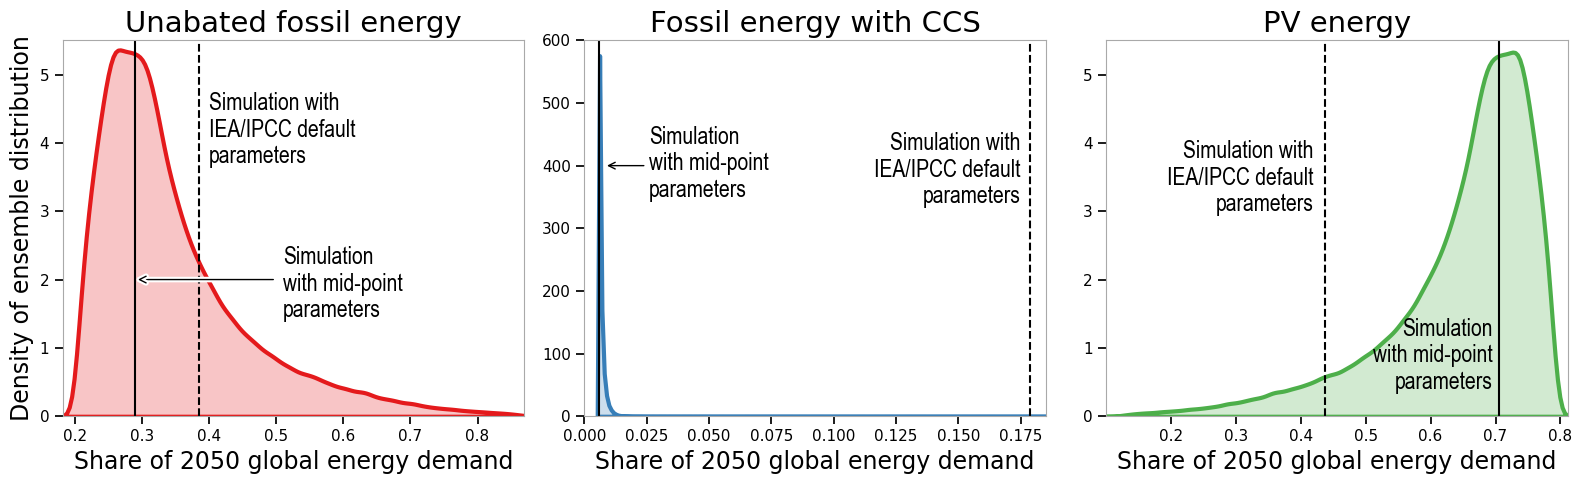

In [219]:
# Figure 5
sns.set_context("notebook")
locations = ["upper right", "center right", "upper left"]
energy_sources = list(df["energy_source"].unique())
base_palette = sns.color_palette("Set1", n_colors=len(energy_sources))
annotation_font = "Arial Narrow"
annotation_size = 17
titlesize = 21
xylabelsize = 17
ticklabelsize = 12
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, e in enumerate(energy_sources):
    ax = axes[i]

    # distribution of ensemble member results
    kdeplot = sns.kdeplot(
        data=df.loc[df.energy_source == e, "2050"],
        common_norm=True,
        ax=ax,
        fill=True,
        lw=3,
        color=base_palette[i],
    )

    # baseline simulation result for each energy source
    ax.plot(
        [baseline_df.loc[e, "default_pars_2050"]] * 2,
        ax.get_ylim(),
        color="k",  # base_palette[i],
        ls="--",
        lw=1.5,
    )
    # midpoint simulation with realistic carbon price forcing
    ax.plot(
        [midpoint_df.loc[e, "midpoint_pars_2050"]] * 2,
        ax.get_ylim(),
        color="k",  # base_palette[i],
        ls="-",
        lw=1.5,
    )

    for spine in ax.spines.values():
        spine.set_linewidth(0.8)
        spine.set_color("darkgrey")
    # adjust x axis limits
    ax.set_xlim(
        [
            df.loc[df.energy_source == e, "2050"].min() - 0.02,
            df.loc[df.energy_source == e, "2050"].quantile(0.9995) + 0.02,
        ]
    )

    ax.set_ylabel("Density of ensemble distribution", fontsize=xylabelsize)
    ax.set_xlabel("Share of 2050 global energy demand", fontsize=xylabelsize)
    if i > 0:
        ax.set_ylabel("")

# --- subplot titles ---
axes[0].set_title("Unabated fossil energy", fontsize=titlesize)
axes[1].set_title("Fossil energy with CCS", fontsize=titlesize)
axes[2].set_title("PV energy", fontsize=titlesize)

# --- add annotations ---
# fossil fuels panel
axes[0].text(
    0.4,
    3.7,
    "Simulation with\nIEA/IPCC default\nparameters",
    fontsize=annotation_size,
    font=annotation_font,
)
axes[0].text(
    0.51,
    1.45,
    "Simulation\nwith mid-point\nparameters",
    font=annotation_font,
    fontsize=annotation_size,
    ha="left",
)
arrow = axes[0].annotate(
    "",
    xytext=(0.5, 2),
    xy=(0.29, 2),
    arrowprops={"arrowstyle": "->"},
)
arrow.arrow_patch.set_path_effects(
    [pe.Stroke(linewidth=4, foreground="white"), pe.Normal()]
)
axes[0].set_ylim(0.0, 5.5)

# add annotations to fossil fuels with CCS panel
axes[1].set_xlim(0.0, 0.185)
axes[1].set_ylim(0, 600)
axes[1].text(
    0.175,
    340,
    "Simulation with\nIEA/IPCC default\nparameters",  # \n(>99.99% of all\nsimulated shares)",
    fontsize=annotation_size,
    font=annotation_font,
    ha="right",
)
axes[1].text(
    0.026,
    350,
    "Simulation\nwith mid-point\nparameters",
    font=annotation_font,
    fontsize=annotation_size,
)
axes[1].annotate(
    "", xytext=(0.025, 400), xy=(0.008, 400), arrowprops=dict(arrowstyle="->")
)

# add annotations to solar PV share panel
axes[2].text(
    0.42,
    3,
    "Simulation with\nIEA/IPCC default\nparameters",
    ha="right",
    fontsize=annotation_size,
    font=annotation_font,
)
axes[2].set_ylim(0, 5.5)

axes[2].text(
    0.695,
    0.4,
    "Simulation\nwith mid-point\nparameters",
    ha="right",
    fontsize=annotation_size,
    font=annotation_font,
)

# tighten things up and save!
fig.tight_layout()
fig.savefig("fig_4.png")
fig.savefig("fig_4.pdf")

In [81]:
del df, s1_df, st_df, pars_df